# Proyecto - Diego Ochoa


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report,
    precision_recall_curve, roc_curve,
    brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

## Carga de datos

In [2]:
train = pd.read_csv('tic_training_data.csv')
test  = pd.read_csv('tic_test_data.csv')

print("Train shape:", train.shape)
print("Test  shape:", test.shape)


Train shape: (5822, 86)
Test  shape: (4000, 85)


Eliminar Duplicados

In [3]:
n_dup = train.duplicated().sum()
print("Duplicados:", n_dup)

train = train.drop_duplicates()

Duplicados: 602


Valores faltantes

In [4]:
print("Valores faltantes en el train dataset:", train.isnull().sum().sum())

Valores faltantes en el train dataset: 0


### Distribucion de la variable target

In [5]:
prop = train['CARAVAN'].value_counts(normalize=True)
print("\nDistribución de CARAVAN:\n", prop)


Distribución de CARAVAN:
 CARAVAN
0    0.934866
1    0.065134
Name: proportion, dtype: float64


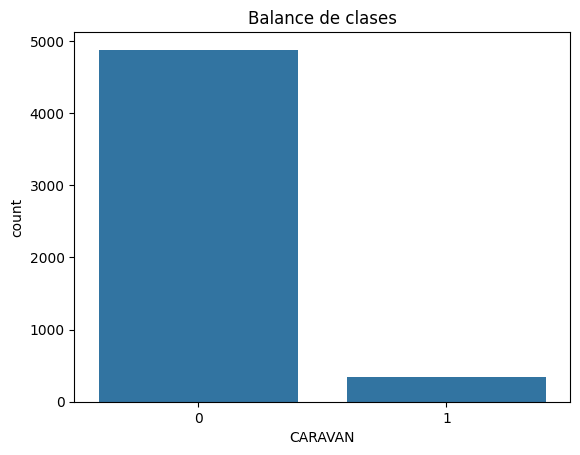

In [6]:
sns.countplot(x='CARAVAN', data=train)
plt.title("Balance de clases")
plt.show()

## EDA y selección inicial

### Correlación lineal con la clase

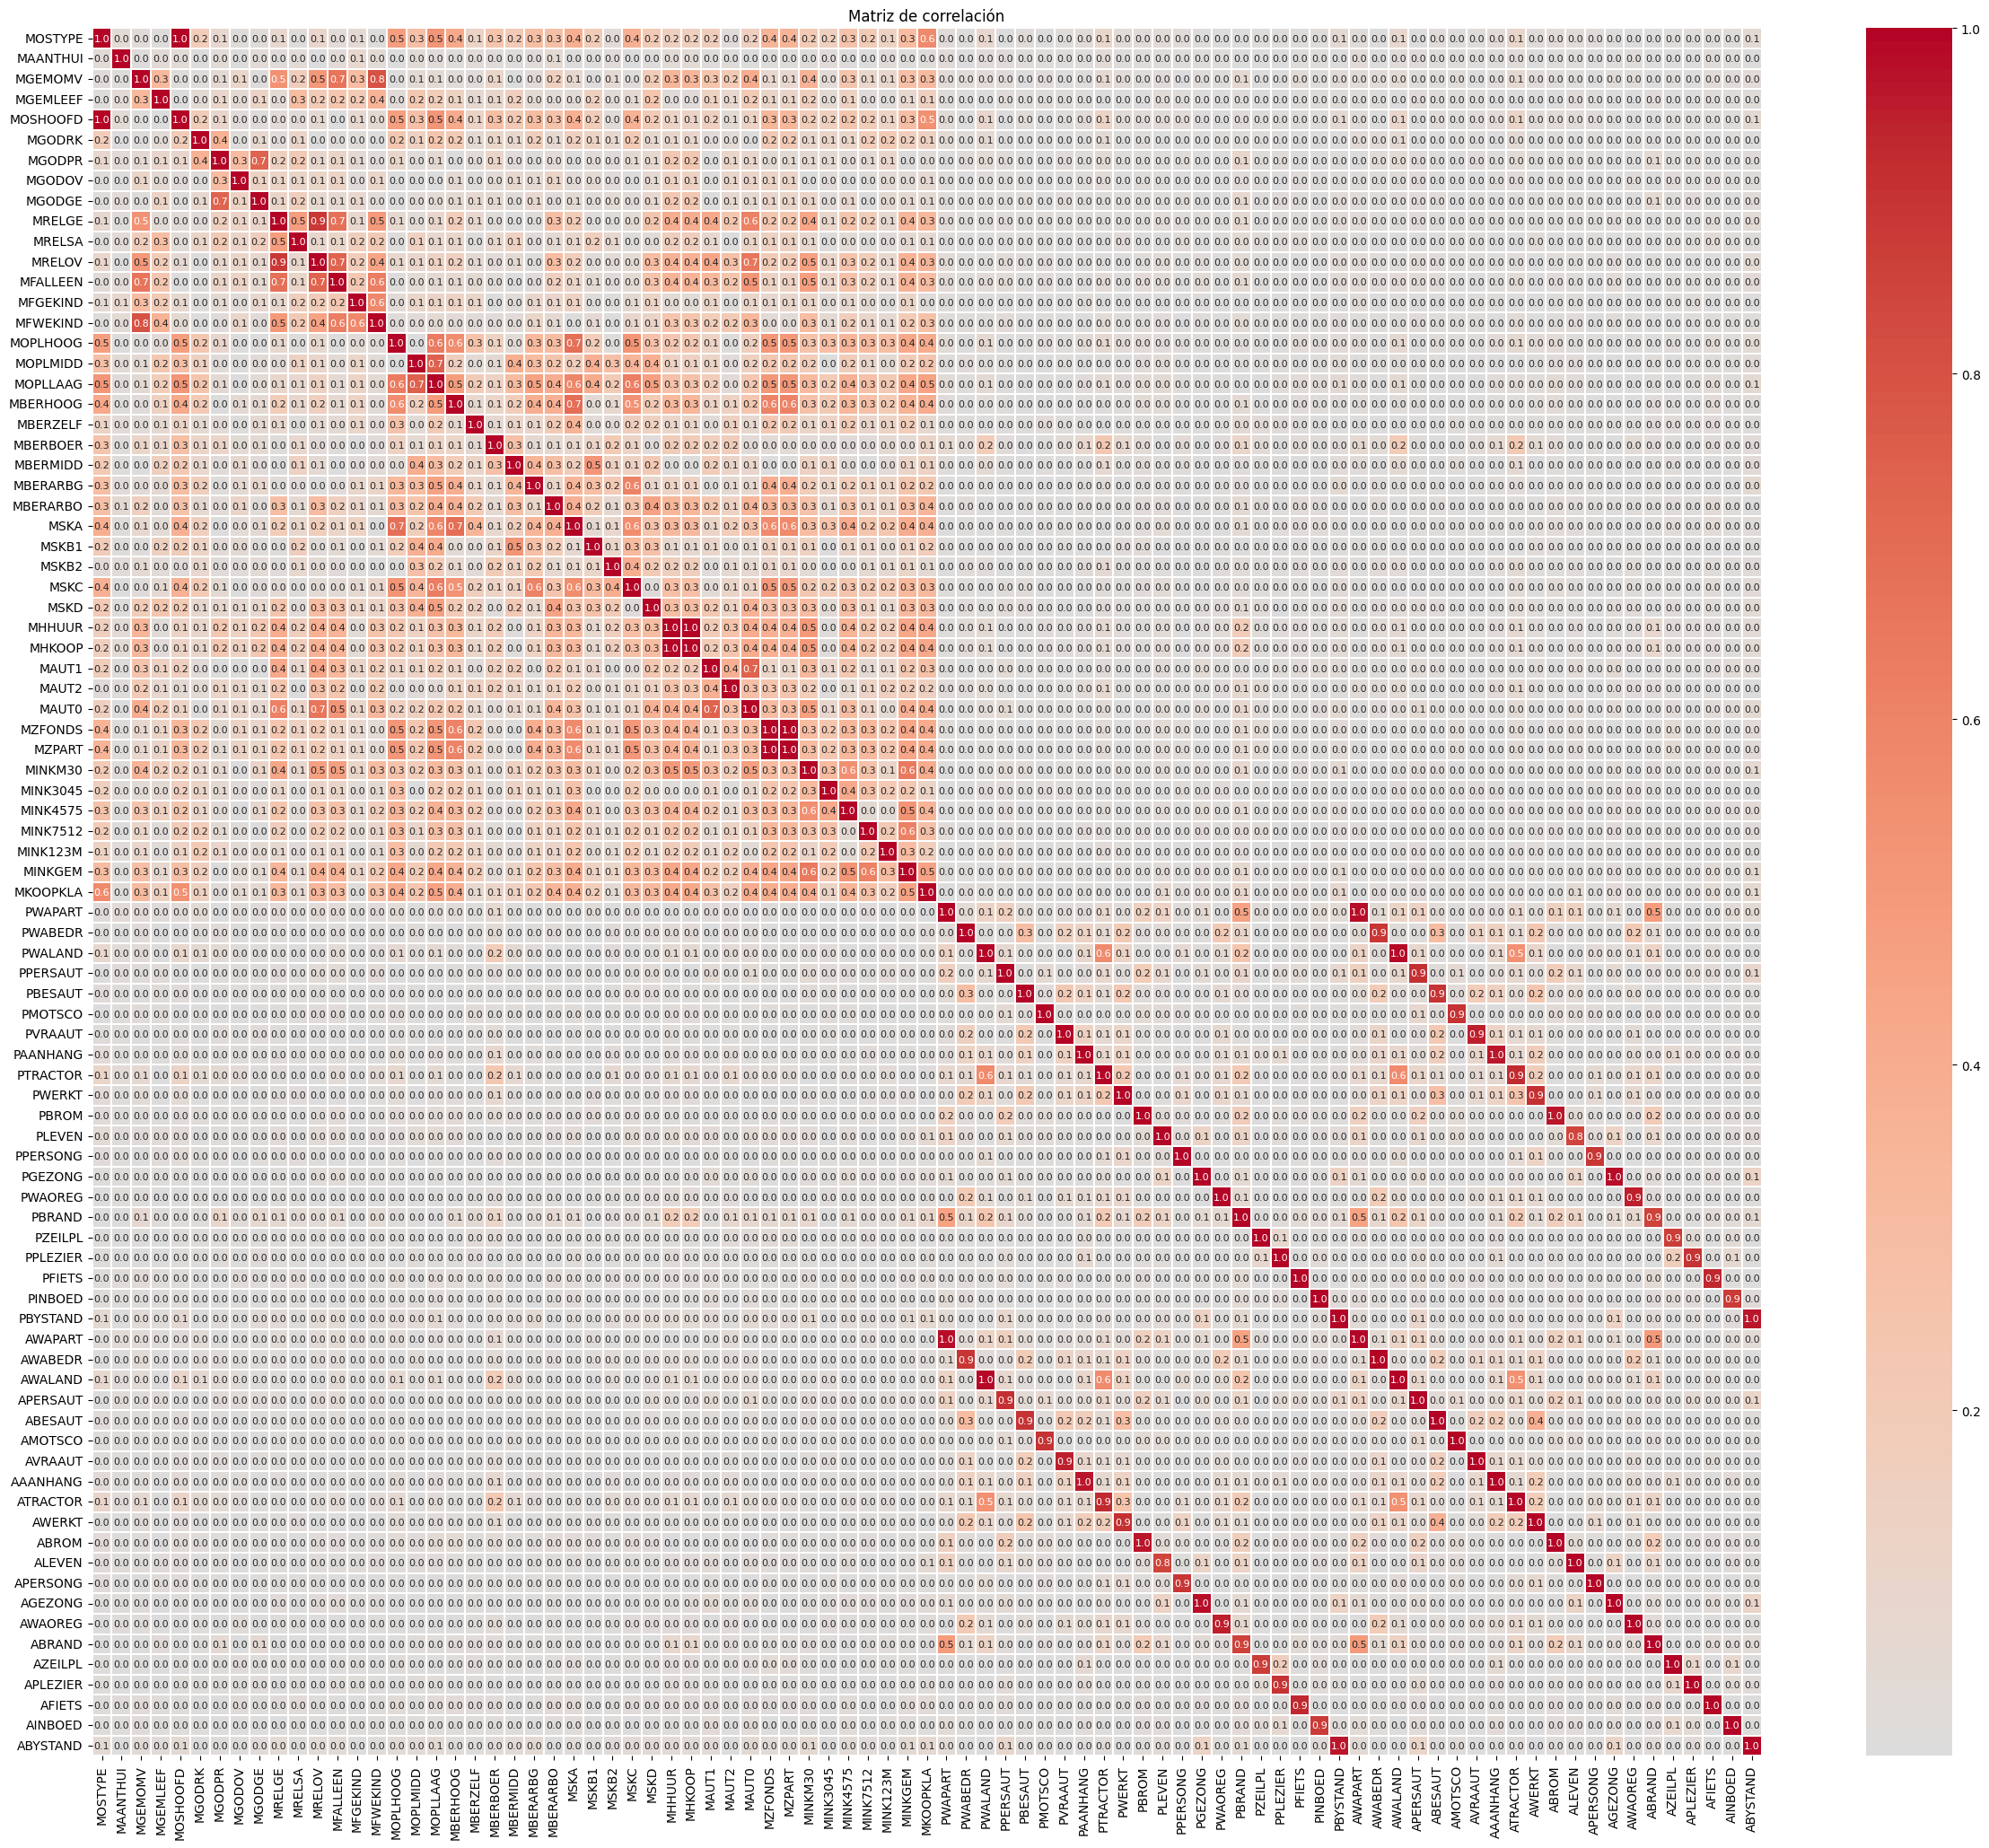

In [7]:
num_feats = train.columns.drop('CARAVAN')
corrmat = train[num_feats].corr().abs()

plt.figure(figsize=(30, 25))
sns.heatmap(corrmat, cmap='coolwarm', center=0, fmt=".1f", linewidths=0.2, annot=True, annot_kws={"size": 8})
plt.title("Matriz de correlación")
plt.show()

Los pares de features que tienen correlacion absoluta mayor a 9.0

In [8]:
num_feats = train.columns.drop('CARAVAN')

corr = train[num_feats].corr().abs()

high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # parte superior de la matriz
    .stack()
    .loc[lambda x: x > 0.9]
)

high_corr

,,0
MOSTYPE,MOSHOOFD,0.992801
MHHUUR,MHKOOP,0.999529
MZFONDS,MZPART,0.999202
PWAPART,AWAPART,0.979798
PWALAND,AWALAND,0.987549
PPERSAUT,APERSAUT,0.911019
PBESAUT,ABESAUT,0.902919
PMOTSCO,AMOTSCO,0.903899
PVRAAUT,AVRAAUT,0.948656
PAANHANG,AAANHANG,0.966042


Revision de que variables tienen menor correlacion con la variable target: CARAVAN

In [9]:
high_corr_pairs = [
    ('MOSTYPE', 'MOSHOOFD'),
    ('MHHUUR', 'MHKOOP'),
    ('MZFONDS', 'MZPART'),
    ('PWAPART', 'AWAPART'),
    ('PWALAND', 'AWALAND'),
    ('PPERSAUT', 'APERSAUT'),
    ('PBESAUT', 'ABESAUT'),
    ('PMOTSCO', 'AMOTSCO'),
    ('PVRAAUT', 'AVRAAUT'),
    ('PAANHANG', 'AAANHANG'),
    ('PTRACTOR', 'ATRACTOR'),
    ('PWERKT', 'AWERKT'),
    ('PBROM', 'ABROM'),
    ('PGEZONG', 'AGEZONG'),
    ('PWAOREG', 'AWAOREG'),
    ('PPLEZIER', 'APLEZIER'),
    ('PFIETS', 'AFIETS'),
    ('PBYSTAND', 'ABYSTAND'),
]

target_corr = train.corrwith(train['CARAVAN']).abs()

lista_eliminar = []

for var1, var2 in high_corr_pairs:
    corr1 = target_corr.get(var1, 0)
    corr2 = target_corr.get(var2, 0)

    if corr1 < corr2:
        lista_eliminar.append(var1)
    else:
        lista_eliminar.append(var2)

print("Variables a eliminar por tener menor correlación con CARAVAN:")
print(lista_eliminar)


Variables a eliminar por tener menor correlación con CARAVAN:
['MOSHOOFD', 'MHKOOP', 'MZPART', 'AWAPART', 'AWALAND', 'APERSAUT', 'PBESAUT', 'PMOTSCO', 'AVRAAUT', 'AAANHANG', 'PTRACTOR', 'AWERKT', 'PBROM', 'AGEZONG', 'AWAOREG', 'PPLEZIER', 'PFIETS', 'PBYSTAND']


Eliminamos las variables identificadas

In [10]:
train = train.drop(columns=lista_eliminar)
test = test.drop(columns=lista_eliminar)

## Preparación de datos

In [11]:
X = train.drop(columns=['CARAVAN'])
y = train['CARAVAN']

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=40)
X_train_kbest = selector.fit_transform(X_tr, y_tr)
X_val_kbest = selector.transform(X_va)

In [14]:
selected_columns = X_tr.columns[selector.get_support()]
print("Variables seleccionadas:", selected_columns)

Variables seleccionadas: Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODPR', 'MGODOV',
       'MGODGE', 'MRELGE', 'MRELOV', 'MFALLEEN', 'MOPLLAAG', 'MBERHOOG',
       'MBERBOER', 'MBERMIDD', 'MBERARBO', 'MSKA', 'MSKD', 'MHHUUR', 'MAUT0',
       'MZFONDS', 'MINKM30', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA',
       'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PWERKT', 'PLEVEN',
       'PPERSONG', 'PBRAND', 'PINBOED', 'ATRACTOR', 'ABROM', 'ALEVEN',
       'APERSONG', 'APLEZIER', 'AFIETS'],
      dtype='object')


### Logistic Regression

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [16]:
# sm = SMOTE(sampling_strategy=0.3, random_state=42)
# X_res, y_res = sm.fit_resample(X_train_kbest, y_tr)

In [17]:
scaler = StandardScaler()
X_res_s = scaler.fit_transform(X_train_kbest)
X_va_s  = scaler.transform(X_val_kbest)

In [18]:
lr = LogisticRegression(
    solver='saga',
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)

In [19]:
lr.fit(X_res_s, y_tr)

proba_lr = lr.predict_proba(X_va_s)[:,1]
print("AUC:", roc_auc_score(y_va, proba_lr))

AUC: 0.7365263045108754


In [20]:
param_grid = {
    'penalty':   ['l1', 'l2', 'elasticnet'],
    'C':         [0.01, 0.1, 1, 10],
    'l1_ratio':  [0.1, 0.5, 0.9]
}

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [22]:
grid.fit(X_res_s, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, random_state=42,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc', verbose=1)

In [23]:
print("Mejores parámetros:", grid.best_params_)
print("Mejor AUC CV (LR):", grid.best_score_)

Mejores parámetros: {'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'elasticnet'}
Mejor AUC CV (LR): 0.7436288500330919


Evaluacion final

In [24]:
proba_va = grid.predict_proba(X_va_s)[:,1]
print("AUC en validación:", roc_auc_score(y_va, proba_va))
print("\nClassification report:")
print(classification_report(y_va, grid.predict(X_va_s)))

AUC en validación: 0.743782144005143

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1464
           1       0.12      0.68      0.21       102

    accuracy                           0.67      1566
   macro avg       0.55      0.67      0.50      1566
weighted avg       0.91      0.67      0.75      1566



Con Test


AUC en test: 0.71453142660573

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      3762
           1       0.11      0.63      0.19       238

    accuracy                           0.69      4000
   macro avg       0.54      0.66      0.50      4000
weighted avg       0.92      0.69      0.77      4000



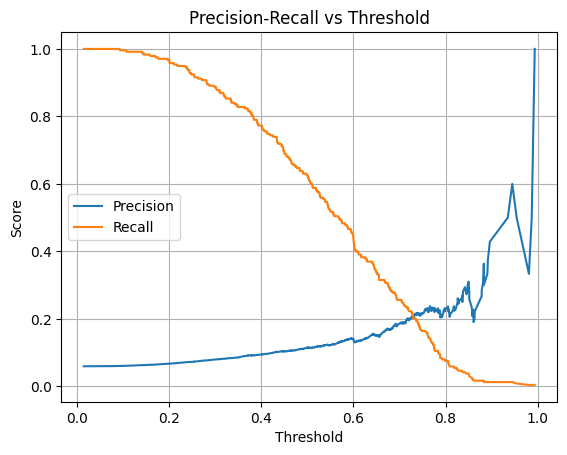


Classification Report (Threshold=0.3):
              precision    recall  f1-score   support

           0       0.98      0.35      0.52      3762
           1       0.08      0.89      0.15       238

    accuracy                           0.38      4000
   macro avg       0.53      0.62      0.33      4000
weighted avg       0.93      0.38      0.50      4000



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve


y_test = pd.read_csv('tictgts2000.txt', header=None, names=['CARAVAN'])['CARAVAN']


X_test_kbest = selector.transform(test)
X_test_s = scaler.transform(X_test_kbest)


proba_test = grid.predict_proba(X_test_s)[:, 1]
y_pred_test = grid.predict(X_test_s)


print("AUC en test:", roc_auc_score(y_test, proba_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


precision, recall, thresholds = precision_recall_curve(y_test, proba_test)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid()
plt.show()


custom_threshold = 0.3
y_pred_custom = (proba_test >= custom_threshold).astype(int)

print(f"\nClassification Report (Threshold={custom_threshold}):")
print(classification_report(y_test, y_pred_custom))


resultados = test.copy()
resultados['proba_caravan_1'] = proba_test
resultados['pred_caravan_custom'] = y_pred_custom
resultados.to_csv("predicciones_test_con_resultados.csv", index=False)


In [26]:

custom_threshold = 0.4
y_pred_custom = (proba_test >= custom_threshold).astype(int)

print(f"\nClassification Report (Threshold={custom_threshold}):")
print(classification_report(y_test, y_pred_custom))

resultados = test.copy()
resultados['proba_caravan_1'] = proba_test
resultados['pred_caravan_custom'] = y_pred_custom
resultados.to_csv("predicciones_test_con_resultados.csv", index=False)


Classification Report (Threshold=0.4):
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      3762
           1       0.09      0.77      0.17       238

    accuracy                           0.55      4000
   macro avg       0.53      0.65      0.43      4000
weighted avg       0.92      0.55      0.66      4000



Mejor umbral por F1-score: 0.6914
F1-score máximo: 0.2211

Classification Report (Umbral óptimo por F1):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3762
           1       0.19      0.27      0.22       238

    accuracy                           0.89      4000
   macro avg       0.57      0.60      0.58      4000
weighted avg       0.91      0.89      0.90      4000



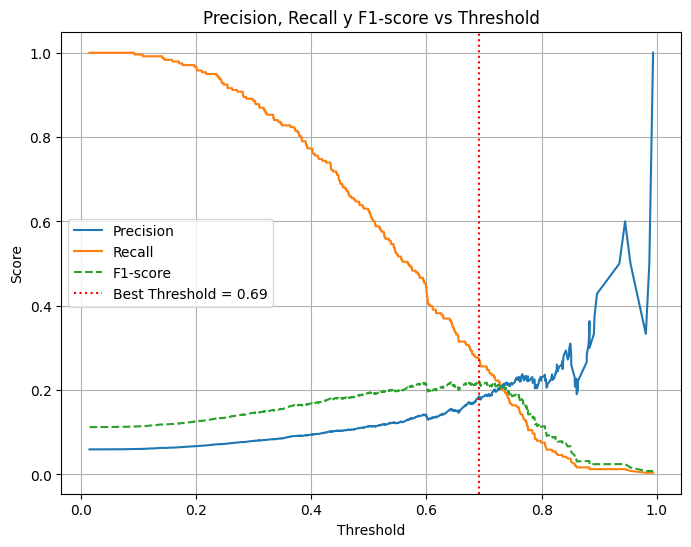

In [27]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_test, proba_test)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor umbral por F1-score: {best_threshold:.4f}")
print(f"F1-score máximo: {best_f1:.4f}")

y_pred_opt = (proba_test >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print("\nClassification Report (Umbral óptimo por F1):")
print(classification_report(y_test, y_pred_opt))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall y F1-score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()
